# SambaTV Challenge:

## Preliminary

Let's start by loading everything we need and examining the data. Then we can start digging in.

In [1]:
%matplotlib inline
import statsmodels.api as sm
import pandas as pd
from matplotlib import pyplot as plt
from pandasql import sqldf
from __future__ import division
import datetime as dt
import numpy as np
pysqldf = lambda q: sqldf(q, globals())

pd.set_option('display.mpl_style', 'default')

/Users/acandela/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
#load data
test = pd.read_csv('test_table.csv',sep=',',header=0)
user = pd.read_csv('user_table.csv',sep=',',header=0)

test['date']=pd.to_datetime(test['date'],format='%Y-%m-%d')


In [102]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [20]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [21]:
user.describe(include='all')

,user_id,sex,age,country
count,452867.000000,452867,452867.000000,452867
unique,NaN,2,NaN,17
top,NaN,M,NaN,Mexico
freq,NaN,264485,NaN,128484
mean,499944.805166,NaN,27.130740,NaN
std,288676.264784,NaN,6.776678,NaN
min,1.000000,NaN,18.000000,NaN
25%,249819.000000,NaN,22.000000,NaN
50%,500019.000000,NaN,26.000000,NaN
75%,749543.000000,NaN,31.000000,NaN


In [22]:
test.describe(include='all')

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
count,453321.000000,453321,453321,453321,453321,181877,453321,453321.000000,453321.000000
unique,NaN,5,3,2,3,5,7,NaN,NaN
top,NaN,2015-12-04 00:00:00,Ads,Web,ES,Facebook,Android_App,NaN,NaN
freq,NaN,141163,181877,251565,377547,68425,155135,NaN,NaN
first,NaN,2015-11-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2015-12-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,499937.514728,NaN,NaN,NaN,NaN,NaN,NaN,0.049579,0.476446
std,288665.193436,NaN,NaN,NaN,NaN,NaN,NaN,0.217073,0.499445
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,249816.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000


In [12]:
test.describe()

,user_id,conversion,test
count,453321.000000,453321.000000,453321.000000
mean,499937.514728,0.049579,0.476446
std,288665.193436,0.217073,0.499445
min,1.000000,0.000000,0.000000
25%,249816.000000,0.000000,0.000000
50%,500019.000000,0.000000,0.000000
75%,749522.000000,0.000000,1.000000
max,1000000.000000,1.000000,1.000000


In [25]:
test.isnull().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
dtype: int64

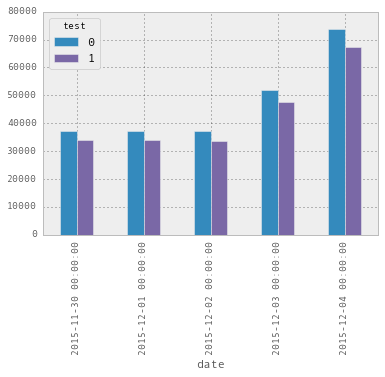

In [103]:
#check dates for test - nothing strange here. Lots more users on the 4th and 3rd (weekend? - no, 4th was a Friday)
test.groupby(['date','test']).count().unstack()['user_id'].plot(kind='bar',stacked=False)

### So far so good.
Looks like there is nothing wrong with the data at the outset (null vals, duplicate users etc). Let's join the two datasets and get one with all of the user dimensions included. It's probably not best practice to load everything into mem right at the get go, but the data size is pretty manageable so I'll do it.

In [3]:
df=pd.merge(test,user,how='inner',on='user_id')

In [160]:
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country,control
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32,Spain,1
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico,0
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain,1
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico,0
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico,0


In [105]:
#plot overall response rate
q="""select
    test,
    sum(conversion) as conversions,
    count(conversion) as users
from
    df
group by
    test
"""
total_rr=pysqldf(q)
total_rr['response_rate']=total_rr['conversions']/total_rr['users']
total_rr

,test,conversions,users,response_rate
0,0,13077,237093,0.055156
1,1,9367,215774,0.043411


# Why does the XYZ company think test was negative?
I assume that they looked at the above response rate and immediately gave up. I suspect the poor result is due to a **simpsons paradox** like effect. Let's plot response rate by country to see if the negative results hold when sliced by country.

In [163]:
#use this later
country_conversions=df.groupby(['test','country']).sum()['conversion']
country_counts=df.groupby(['test','country']).count()['conversion']

In [4]:
query="""select
    country,
    test,
    sum(conversion) as conversions,
    count(conversion) as users
from
    df
group by
    country,
    test
"""
rr=pysqldf(query)

In [5]:
#add a column computing response rate (because it uses integer division when I run it in the SQL)
rr['response_rate']=rr['conversions']/rr['users']

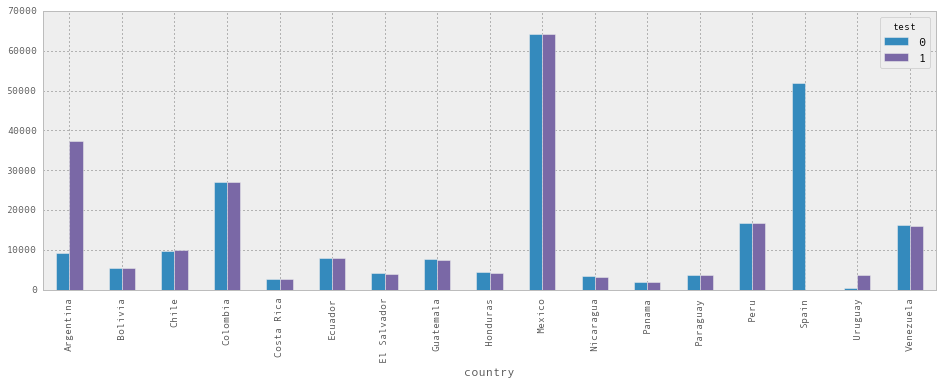

In [7]:
#plot user counts by country to see how bad skew by test/control counts might be
rr.groupby(['country','test']).sum().unstack()['users'].plot(kind='bar',stacked=False,figsize=(16, 5))
#rr.groupby(['country','test']).sum().unstack()['users']

In [9]:
#rr.groupby(['country','test']).sum().unstack()['response_rate'].plot(kind='bar',stacked=False,figsize=(15, 4))
rr.groupby(['test','country']).sum().unstack()['response_rate']

country,Argentina,Bolivia,Chile,Colombia,Costa Rica,Ecuador,El Salvador,Guatemala,Honduras,Mexico,Nicaragua,Panama,Paraguay,Peru,Spain,Uruguay,Venezuela
test,,,,,,,,,,,,,,,,,
0,0.015071,0.049369,0.048107,0.052089,0.052256,0.049154,0.053554,0.050643,0.050906,0.049495,0.052647,0.046796,0.048493,0.049914,0.079719,0.012048,0.050344
1,0.013725,0.047901,0.051295,0.050571,0.054738,0.048988,0.047947,0.048647,0.047540,0.051186,0.054177,0.049370,0.049229,0.050604,NaN,0.012907,0.048978


OK looks like some countries appear successful while others don't. That's good, because it confirms my suspicion that there is some information lost when we aggregate over everything. Oh! Look at this...
### Spain has a vastly higher response rate than all of the other countries. Since it also has no test population, if I include Spain in other aggregations, it will drag up the percieved response rate of the control group (when I aggregate over country).

### Also Argentina has much more (almost 4x) test users than control users. Since Argentina has a terrible response rate (almost as bad as uruguay) it will also drag the overall test results down. Uruguay also has way more test users than control users (proportionally). 

So this is looking good for my theory. Let's remove Spain, Argentina and Uruguay from the test altogether and see if any of the other variables look significant overall.
This is gonna be a pain cause I'm still weak with Pandas, but let's get to work

In [112]:
#remove countries with poor test conditions (number of test and control users are not equal)
df_scrubbed=df[~df.country.isin(['Spain','Uruguay','Argentina'])]

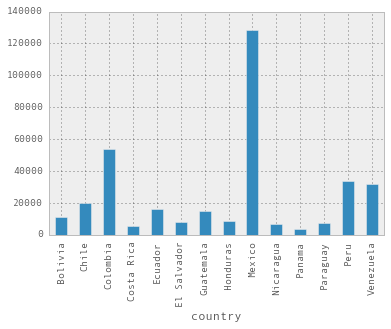

In [130]:
#make sure I did this correctly
df_scrubbed.groupby('country').count()['user_id'].plot(kind='bar')

In [114]:
qgender="""select
    sex,
    test,
    sum(conversion) as conversions,
    count(conversion) as users
from
    df_scrubbed
group by
    sex,
    test
"""
gender_rr=pysqldf(qgender)

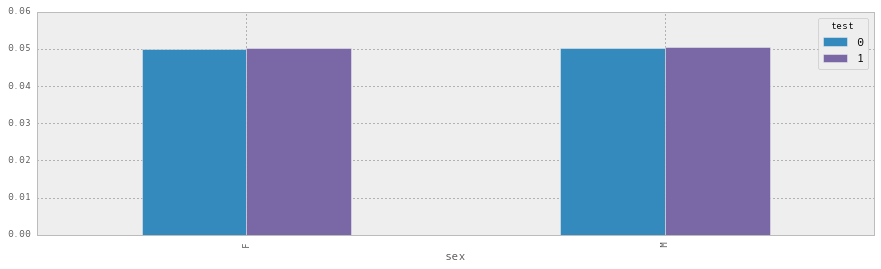

In [115]:
gender_rr['response_rate']=gender_rr['conversions']/gender_rr['users']
gender_rr.groupby(['sex','test']).sum().unstack()['response_rate'].plot(kind='bar',stacked=False,figsize=(15, 4))

### OK - Gender is not a factor on it's own it seems

In [116]:
qsource="""select
    source,
    test,
    sum(conversion) as conversions,
    count(conversion) as users
from
    df_scrubbed
group by
    source,
    test
"""
source_rr=pysqldf(qsource)

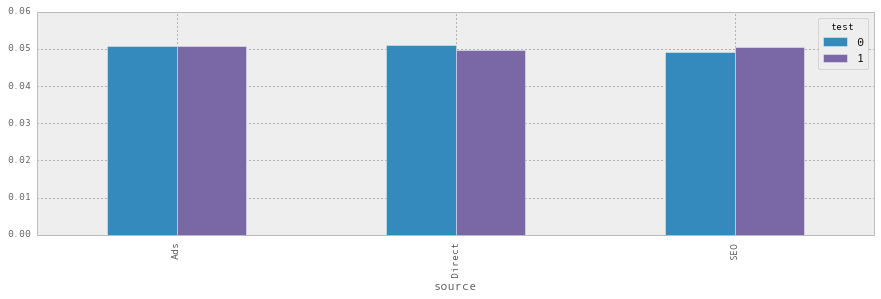

In [117]:
source_rr['response_rate']=source_rr['conversions']/source_rr['users']
source_rr.groupby(['source','test']).sum().unstack()['response_rate'].plot(kind='bar',stacked=False,figsize=(15, 4))

### Neither is source 

In [118]:
qdevice="""select
    device,
    test,
    sum(conversion) as conversions,
    count(conversion) as users
from
    df_scrubbed
group by
    device,
    test
"""
device_rr=pysqldf(qdevice)

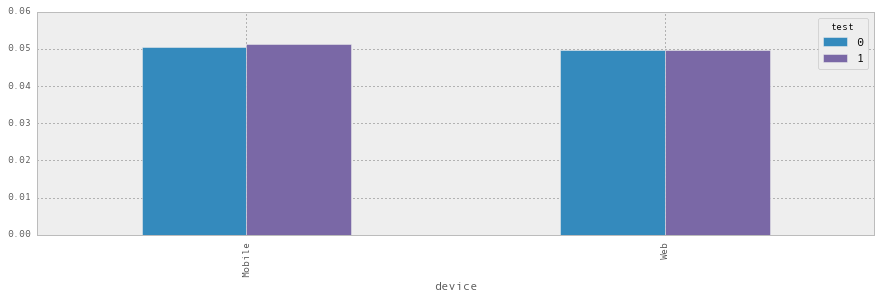

In [119]:
device_rr['response_rate']=device_rr['conversions']/device_rr['users']
device_rr.groupby(['device','test']).sum().unstack()['response_rate'].plot(kind='bar',stacked=False,figsize=(15, 4))

### Device also doesn't seem to be a driver of increased performance

In [120]:
qbrowserlanguage="""select
    browser_language,
    test,
    sum(conversion) as conversions,
    count(conversion) as users
from
    df_scrubbed
group by
    browser_language,
    test
"""
device_bl=pysqldf(qbrowserlanguage)

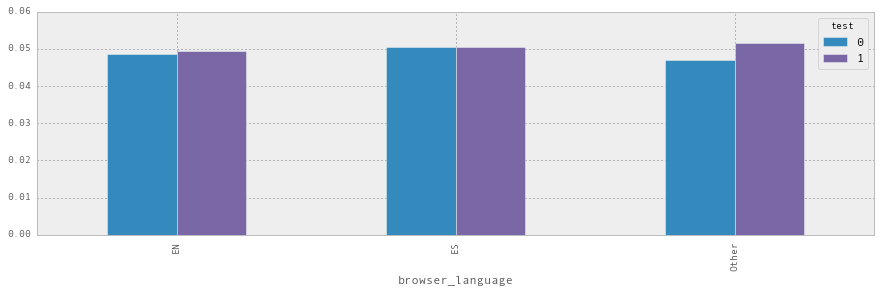

In [121]:
device_bl['response_rate']=device_bl['conversions']/device_bl['users']
device_bl.groupby(['browser_language','test']).sum().unstack()['response_rate'].plot(kind='bar',stacked=False,figsize=(15, 4))

### OK Browser language may be indicative. Other seems to perform slightly better

In [122]:
qads_channel="""select
    ads_channel,
    test,
    sum(conversion) as conversions,
    count(conversion) as users
from
    df_scrubbed
group by
    ads_channel,
    test
"""
ads_ch=pysqldf(qads_channel)


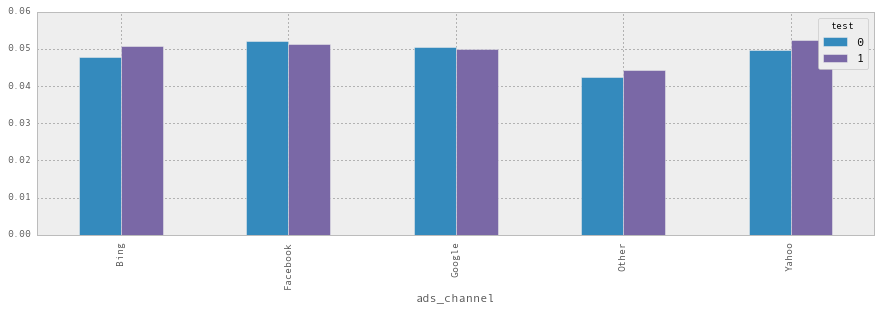

In [123]:
ads_ch['response_rate']=ads_ch['conversions']/ads_ch['users']
ads_ch.groupby(['ads_channel','test']).sum().unstack()['response_rate'].plot(kind='bar',stacked=False,figsize=(15, 4))

### ADS Channel seems to be a mixed bag too

In [124]:
qbrowser="""select
    browser,
    test,
    sum(conversion) as conversions,
    count(conversion) as users
from
    df_scrubbed
group by
    browser,
    test
"""
browser=pysqldf(qbrowser)

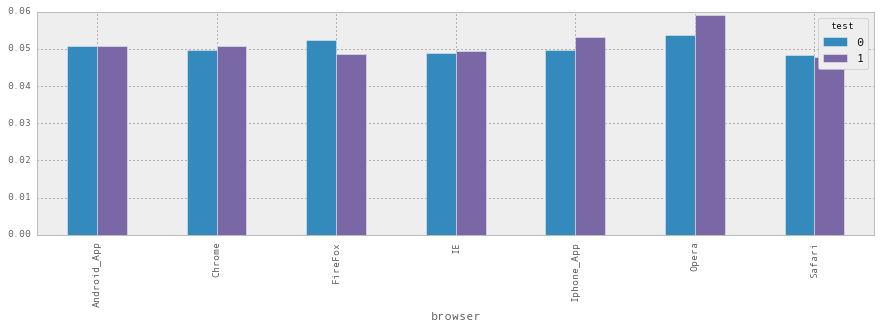

In [125]:
browser['response_rate']=browser['conversions']/browser['users']
browser.groupby(['browser','test']).sum().unstack()['response_rate'].plot(kind='bar',stacked=False,figsize=(15, 4))

### browser may drive some performance
It's a long shot - but maybe date??

In [126]:
qdate="""select
    date,
    test,
    sum(conversion) as conversions,
    count(conversion) as users
from
    df_scrubbed
group by
    date,
    test
"""
date=pysqldf(qdate)

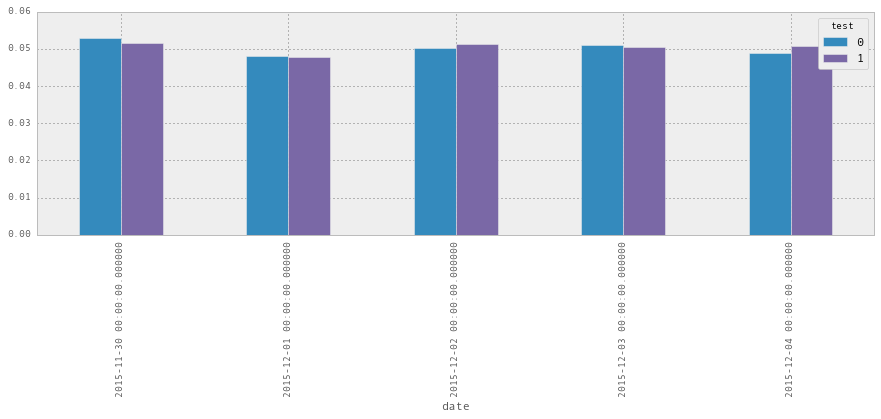

In [127]:
date['response_rate']=date['conversions']/date['users']
date.groupby(['date','test']).sum().unstack()['response_rate'].plot(kind='bar',stacked=False,figsize=(15, 4))

### Date doesn't seem to matter.
Maybe age? It looks discrete enough to not have to bucket them

In [128]:
qage="""select
    age,
    test,
    sum(conversion) as conversions,
    count(conversion) as users
from
    df_scrubbed
group by
    age,
    test
"""
age=pysqldf(qage)

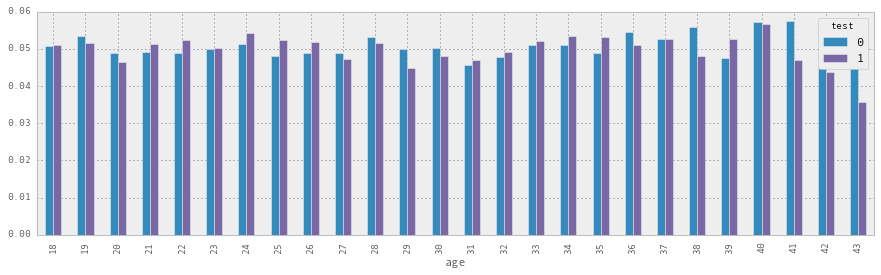

In [129]:
age=age[age['users'] >= 1000]
age['response_rate']=age['conversions']/age['users']
age.groupby(['age','test']).sum().unstack()['response_rate'].plot(kind='bar',stacked=False,figsize=(15, 4))

### Age is a mixed bag too. 

# Conclusion:
I would not say the test is conclusively negative. There are many factors which appear to drive performance and could very well be predictors of higher performance for test vs control. Right off the bat - some countries perform better than others (according to Response Rate by test and control groups). It may be worthwhile to create specific translations for certain countries (like Mexico, which has many users and also a higher response rate for test than control). Whether or not that is worth doing depends on some practical conditions - like if the added cost of another translation is made up for by the increase in performance.

## The problems with this test:
This test suffers from a classic example of Simpson's Paradox (https://en.wikipedia.org/wiki/Simpson%27s_paradox). There is quite a bit of variation in the test results when sliced by country, but you lose that information when you aggregate over the country variable. 
Adding to this the inequalities of the sizes of test and control groups per country, and you can see pretty wild distortion. In this case, the employees at XYZ were unlucky in that the two countries with much higher test users than control users (Uruguay and Argentina) had overall response rates that were far below the overall average. Also Spain had **NO** test users, and the highest response rate, it further contributed to this problem.


# Correcting for this in the future:
In order to prevent this type of misrepresentation from happening in the future, we would wish to ensure the following:
## Ensure that there is an even as possible distribution of test users to control users per variable.
In this case country was a factor that drove response rates (more so than test and control) and we saw an uneven assignment of test and control users to some countries (the ones with the most extreme response rates). If we are to perform tests like this again, we would wish to run it in a way that assigned users to test and control such that there are an even number of test and control users for every level of every controllable variable.
This is not always possible, but you will be punished more severely if you skew the test and control sizes by a variable that appears to drive performance.



## Algorithm to check reliability of test:
If we wish to perform an algorithmic check on a test of this nature in the future, it could look something like this:
### Psuedocode
    For every predictor variable, see if all levels of that predictor variable have roughly the same number of test and control users. If any of the levels are different (say test is less than 90% of control or greater than 110% of control) then return a warning that the test results may be suspicious.

In [134]:
#assign variable for control to aid calculation
df['control']=[1 if i==0 else 0 for i in df['test']]

In [136]:
#do this for every 'meaningful' column in DF
comp=df.groupby('country').sum()[['test','control']]

In [151]:
for i in comp.iterrows():
    if (i[1]['test']/i[1]['control'] > 1.10) | (i[1]['test']/i[1]['control'] < .9):
        print ('Watch out! Test/control ratio for {} is: {}'.format(i[0],i[1]['test']/i[1]['control']))
    else:
        print('{} is OK!'.format(i[0]))

Watch out! Test/control ratio for Argentina is: 3.99497648568
Bolivia is OK!
Chile is OK!
Colombia is OK!
Costa Rica is OK!
Ecuador is OK!
El Salvador is OK!
Guatemala is OK!
Honduras is OK!
Mexico is OK!
Nicaragua is OK!
Panama is OK!
Paraguay is OK!
Peru is OK!
Watch out! Test/control ratio for Spain is: 0.0
Watch out! Test/control ratio for Uruguay is: 8.96144578313
Venezuela is OK!


In [152]:
#let's try another factor to see if my thresholds are OK
comp_sex=df.groupby('sex').sum()[['test','control']]

In [153]:
for i in comp_sex.iterrows():
    if (i[1]['test']/i[1]['control'] > 1.10) | (i[1]['test']/i[1]['control'] < .9):
        print ('Watch out! Test/control ratio for {} is: {}'.format(i[0],i[1]['test']/i[1]['control']))
    else:
        print('{} is OK!'.format(i[0]))

F is OK!
M is OK!


In [155]:
variables=['date','source','device','browser_language','ads_channel','browser','age','country']

Let's run the whole thing:

In [158]:
for v in variables:
    comp_df=df.groupby(v).sum()[['test','control']]
    for i in comp_df.iterrows():
        if (i[1]['test']/i[1]['control'] > 1.10) | (i[1]['test']/i[1]['control'] < .9):
            print ('Watch out! Test/control ratio for {} is: {}'.format(i[0],i[1]['test']/i[1]['control']))
        #else:
            #print('{} is OK!'.format(i[0]))

Watch out! Test/control ratio for Other is: 0.872119295075
Watch out! Test/control ratio for Safari is: 0.888311090658
Watch out! Test/control ratio for 33 is: 0.897583121912
Watch out! Test/control ratio for 34 is: 0.896111694941
Watch out! Test/control ratio for 38 is: 0.885520125457
Watch out! Test/control ratio for 40 is: 0.88502269289
Watch out! Test/control ratio for 43 is: 0.898939929329
Watch out! Test/control ratio for 44 is: 0.877177700348
Watch out! Test/control ratio for 45 is: 0.850683491062
Watch out! Test/control ratio for 46 is: 0.843293492696
Watch out! Test/control ratio for 50 is: 0.822878228782
Watch out! Test/control ratio for 51 is: 0.884210526316
Watch out! Test/control ratio for 52 is: 0.756578947368
Watch out! Test/control ratio for 54 is: 0.857142857143
Watch out! Test/control ratio for 55 is: 0.816666666667
Watch out! Test/control ratio for 56 is: 1.23076923077
Watch out! Test/control ratio for 57 is: 0.5
Watch out! Test/control ratio for 58 is: 0.36363636363

## OK - I'm happy with these results. 
If we found out that Age was a driver in performance, some of the inequalities in test/control assignment in the age buckets might hurt the test results. Browser version seems to be a little on the unequal side. Maybe I change my thresholds a little based on how annoying these flags get if we continue to use my test.

# logistic regression
I'll try running a logistic regression and take a look at the odds ratio for each factor

In [7]:
print pd.crosstab(df['test'],df['country'])

country  Argentina  Bolivia  Chile  Colombia  Costa Rica  Ecuador  \
test                                                                
0             9356     5550   9853     27088        2660     8036   
1            37377     5574   9884     26972        2649     7859   

country  El Salvador  Guatemala  Honduras  Mexico  Nicaragua  Panama  \
test                                                                   
0               4108       7622      4361   64209       3419    1966   
1               4067       7503      4207   64275       3304    1985   

country  Paraguay   Peru  Spain  Uruguay  Venezuela  
test                                                 
0            3650  16869  51782      415      16149  
1            3697  16797      0     3719      15905  


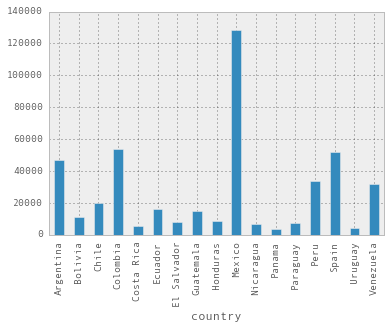

In [17]:
df.groupby(['country']).count()['date'].plot(kind='bar')

In [18]:
#create dummy variables for country
dummy_countries=pd.get_dummies(df['country'])

In [19]:
dummy_countries.head()

,Argentina,Bolivia,Chile,Colombia,Costa Rica,Ecuador,El Salvador,Guatemala,Honduras,Mexico,Nicaragua,Panama,Paraguay,Peru,Spain,Uruguay,Venezuela
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
#join back to df
model_df=df.join(dummy_countries)

In [38]:
model_df['intercept']=1.0

In [66]:
all_cols=model_df.columns
train_cols=[i for i in all_cols if i not in ['conversion','date','user_id','source','device','browser_language','ads_channel','browser','sex','age','country','test']]

In [67]:
train_cols

['Argentina',
 'Bolivia',
 'Chile',
 'Colombia',
 'Costa Rica',
 'Ecuador',
 'El Salvador',
 'Guatemala',
 'Honduras',
 'Mexico',
 'Nicaragua',
 'Panama',
 'Paraguay',
 'Peru',
 'Spain',
 'Uruguay',
 'Venezuela',
 'intercept']

In [68]:
logit=sm.Logit(model_df['conversion'],model_df[train_cols])
result=logit.fit()

Optimization terminated successfully.
         Current function value: 0.194171
         Iterations 14


In [69]:
 print result.summary()

                           Logit Regression Results                           
Dep. Variable:             conversion   No. Observations:               452867
Model:                          Logit   Df Residuals:                   452850
Method:                           MLE   Df Model:                           16
Date:                Tue, 01 Nov 2016   Pseudo R-squ.:                 0.01545
Time:                        17:07:47   Log-Likelihood:                -87934.
converged:                       True   LL-Null:                       -89313.
                                        LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Argentina      -1.3539   1.65e+05   -8.2e-06      1.000     -3.23e+05  3.23e+05
Bolivia        -0.0724   1.65e+05  -4.39e-07      1.000     -3.23e+05  3.23e+05
Chile          -0.0495   1.65e+05     -3e-07    

In [73]:
print(np.exp(result.params))

Argentina      0.258244
Bolivia        0.930131
Chile          0.951665
Colombia       0.984528
Costa Rica     1.028343
Ecuador        0.938949
El Salvador    0.973065
Guatemala      0.950644
Honduras       0.942592
Mexico         0.964514
Nicaragua      1.026407
Panama         0.919191
Paraguay       0.934753
Peru           0.962851
Spain          1.576144
Uruguay        0.236301
Venezuela      0.950912
intercept      0.054960
dtype: float64


In [80]:
#let's run this with only Costa Rica
restricted_data=model_df[model_df['Mexico'] == 1]
restricted_data.describe()

,user_id,conversion,test,age,Argentina,Bolivia,Chile,Colombia,Costa Rica,Ecuador,...,Honduras,Mexico,Nicaragua,Panama,Paraguay,Peru,Spain,Uruguay,Venezuela,intercept
count,128484.000000,128484.000000,128484.000000,128484.000000,128484.0,128484.0,128484.0,128484.0,128484.0,128484.0,...,128484.0,128484.0,128484.0,128484.0,128484.0,128484.0,128484.0,128484.0,128484.0,128484.0
mean,500617.230356,0.050341,0.500257,27.118209,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
std,288400.487613,0.218648,0.500002,6.780547,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,15.000000,0.000000,0.000000,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25%,250716.500000,0.000000,0.000000,22.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50%,500854.500000,0.000000,1.000000,26.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
75%,749689.250000,0.000000,1.000000,31.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
max,999961.000000,1.000000,1.000000,70.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [87]:
logit=sm.Logit(restricted_data['conversion'],restricted_data[['test','intercept']])
result=logit.fit()

Optimization terminated successfully.
         Current function value: 0.199510
         Iterations 7


In [88]:
print result.summary()

                           Logit Regression Results                           
Dep. Variable:             conversion   No. Observations:               128484
Model:                          Logit   Df Residuals:                   128482
Method:                           MLE   Df Model:                            1
Date:                Tue, 01 Nov 2016   Pseudo R-squ.:               3.751e-05
Time:                        18:00:22   Log-Likelihood:                -25634.
converged:                       True   LL-Null:                       -25635.
                                        LLR p-value:                    0.1655
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
test           0.0354      0.026      1.387      0.166        -0.015     0.085
intercept     -2.9551      0.018   -162.417      0.000        -2.991    -2.919


In [89]:
print pd.crosstab(restricted_data['conversion'],restricted_data['test'],rownames=['conversion'])

test            0      1
conversion              
0           61031  60985
1            3178   3290


In [94]:
#
t_test=3290 + 60985
t_control=3178 + 61031
odds_for_test=(3290/t_test)/(60985/t_test)
odds_for_control=(3178/t_control)/(61031/t_control)
print(odds_for_test)
print(odds_for_control)
print(np.log(odds_for_test))
print(np.log(odds_for_control))
print(np.log((odds_for_test/odds_for_control)))

0.0539476920554
0.052071897888
-2.91974036752
-2.95512986369
0.035389496174


In [95]:
result.conf_int()

,0,1
test,-0.014634,0.085413
intercept,-2.990791,-2.919469


In [96]:
result.params

test         0.035389
intercept   -2.955130
dtype: float64